<a href="https://colab.research.google.com/github/yashc73080/CS462-Deep-Learning/blob/main/HW2/features_unsupervised_and_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from tqdm.auto import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

Google Drive mount to save long runs

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!mkdir -p /content/drive/MyDrive/CS462_HW2_Models

# 1. Auto-Encoders

Get MNIST dataloaders

In [ ]:
mnist_tfm = transforms.Compose([transforms.ToTensor()])
mnist_train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=mnist_tfm)
mnist_test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=mnist_tfm)

mnist_train_loader = DataLoader(mnist_train_ds, batch_size=128, shuffle=True, num_workers=2)
mnist_test_loader = DataLoader(mnist_test_ds, batch_size=256, shuffle=False, num_workers=2)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.95MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.7MB/s]


Create Auto-Encoder classes and functions

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_size=784, enc_hidden=500, bottleneck_k=200, dropout_prob=0.0, device='cpu'):
    '''
    Encoder module with architecture: Input (784) -> Hidden -> Bottleneck k
    '''
    super().__init__()

    # Setup linear layers
    layers = []
    layers.append(nn.Linear(input_size, enc_hidden))
    layers.append(nn.ReLU())

    # Optional dropout layer
    if dropout_prob > 0:
      layers.append(nn.Dropout(dropout_prob))

    self.k = bottleneck_k
    layers.append(nn.Linear(enc_hidden, bottleneck_k))

    self.encoder = nn.Sequential(*layers)

  def forward(self, x):
    return self.encoder(x)


class Decoder(nn.Module):
  def __init__(self, bottleneck_k=200, dec_hidden=500, output_size=784, dropout_prob=0.0, device='cpu'):
    '''
    Decoder module with architecture: Bottleneck k -> Hidden -> Output (784)
    '''
    super().__init__()

    # Setup linear layers
    layers = []
    layers.append(nn.Linear(bottleneck_k, dec_hidden))
    layers.append(nn.ReLU())

    # Optional dropout layer
    if dropout_prob > 0:
      layers.append(nn.Dropout(dropout_prob))

    layers.append(nn.Linear(dec_hidden, output_size))

    self.decoder = nn.Sequential(*layers)

  def forward(self, x):
    return self.decoder(x)


class AutoEncoder(nn.Module):
  def __init__(self, in_out_size=784, enc_hidden=500, dec_hidden=500, bottleneck_k=200, dropout_prob=0.0, device='cpu'):
    '''
    AutoEncoder module with architecture: Input (784) -> Hidden -> Bottleneck k -> Hidden -> Output (784)
    '''
    super().__init__()
    # Initialize both encoder and decoder
    self.encoder = Encoder(input_size=in_out_size, enc_hidden=enc_hidden, bottleneck_k=bottleneck_k, dropout_prob=dropout_prob, device=device)
    self.decoder = Decoder(bottleneck_k=bottleneck_k, dec_hidden=dec_hidden, output_size=in_out_size, dropout_prob=dropout_prob, device=device)

    self.to(device)

  def forward(self, x):
    return self.decoder(self.encoder(x))


def train_autoencoder(model, train_loader, optimizer, reconstruction_loss):
  '''
  Training one epoch
  '''
  model.train()
  total_loss = 0.0

  for images, _ in train_loader:
    # Get images without labels
    images = images.view(images.size(0), -1).to(device)

    # Compute loss and backward pass with training images
    optimizer.zero_grad()
    reconstructed = model(images)
    loss = reconstruction_loss(reconstructed, images)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  avg_loss = total_loss / len(train_loader)

  return avg_loss

def test_autoencoder(model, test_loader, reconstruction_loss):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, _ in test_loader:
      images = images.view(images.size(0), -1).to(device)
      reconstructed_images = model(images)
      loss = reconstruction_loss(reconstructed_images, images)
      total_loss += loss.item()

  avg_test_loss = total_loss / len(test_loader)

  return avg_test_loss

def train_test_autoencoder(model, train_loader, test_loader, epochs=5, lr=0.001, plot=False, curr_k=None, device='cpu'):
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=lr)
  reconstruction_loss = nn.MSELoss()

  train_losses = []
  test_losses = []

  tqdm_desc = f"k={curr_k} - Epoch" if curr_k is not None else "Epoch"

  for epoch in tqdm(range(epochs), desc=tqdm_desc):
    # Train and test the model for each epoch
    train_loss = train_autoencoder(model, train_loader, optimizer, reconstruction_loss)
    test_loss = test_autoencoder(model, test_loader, reconstruction_loss)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

  if plot:
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Reconstruction Loss')
    plt.show()

  return train_losses, test_losses

def visualize_reconstructions(model, test_loader, num_images=5):
  model.eval()
  with torch.no_grad():
    images, _ = next(iter(test_loader))
    images = images[:num_images].view(num_images, -1).to(device)
    reconstructed = model(images).cpu().view(-1, 1, 28, 28)

    fig, axes = plt.subplots(2, num_images, figsize=(num_images*1.5, 3))
    for i in range(num_images):
      axes[0, i].imshow(images[i].cpu().view(28, 28), cmap='gray')
      axes[0, i].axis('off')
      axes[1, i].imshow(reconstructed[i].view(28, 28), cmap='gray')
      axes[1, i].axis('off')

    plt.suptitle("Originals (top) vs Reconstructions (bottom)")
    plt.show()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

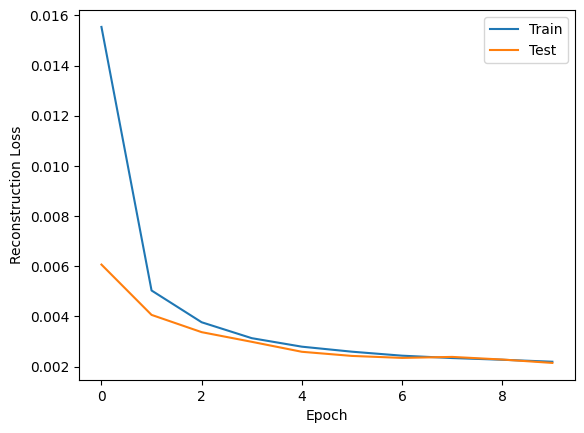

Final Train Loss: 0.0021956156232336693
Final Test Loss: 0.0021477524598594753


In [ ]:
autoencoder = AutoEncoder(in_out_size=784, enc_hidden=1000, dec_hidden=1000, bottleneck_k=200, device=device)
train_losses, test_losses = train_test_autoencoder(autoencoder, mnist_train_loader, mnist_test_loader, epochs=10, lr=0.001, plot=True, device=device)

print(f'Final Train Loss: {train_losses[-1]}')
print(f'Final Test Loss: {test_losses[-1]}')

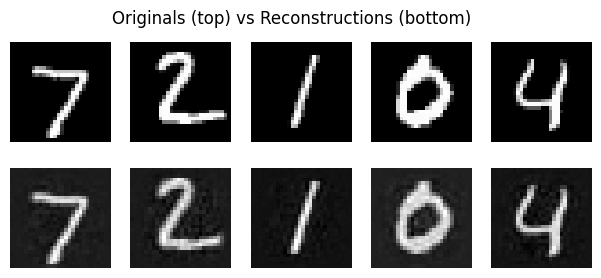

In [ ]:
visualize_reconstructions(autoencoder, mnist_test_loader)

Find best k

k=1 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=3 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=5 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=10 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=20 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=50 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=70 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=100 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=200 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=300 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=500 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

k=700 - Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

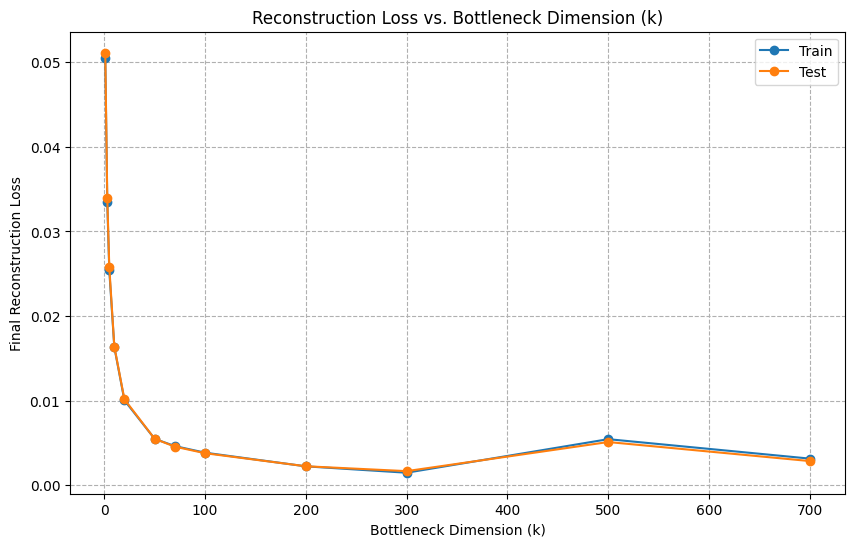

Best k: 300


In [ ]:
possible_k = [1, 3, 5, 10, 20, 50, 70, 100, 200, 300, 500, 700]

train_losses = []
test_losses = []
for k in possible_k:
  autoencoder_k = AutoEncoder(in_out_size=784, enc_hidden=1000, dec_hidden=1000, bottleneck_k=k, device=device)
  train_losses_k, test_losses_k = train_test_autoencoder(autoencoder_k, mnist_train_loader, mnist_test_loader, epochs=10, lr=0.001, plot=False, curr_k=k, device=device)

  train_losses.append(train_losses_k[-1])
  test_losses.append(test_losses_k[-1])

plt.figure(figsize=(10, 6))
plt.plot(possible_k, train_losses, label='Train', marker='o')
plt.plot(possible_k, test_losses, label='Test', marker='o')
plt.legend()
plt.xlabel('Bottleneck Dimension (k)')
plt.ylabel('Final Reconstruction Loss')
plt.title('Reconstruction Loss vs. Bottleneck Dimension (k)')
plt.grid(True, which="both", ls="--")
plt.show()

# Best k based on loss
print(f'Best k: {possible_k[np.argmin(test_losses)]}')

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

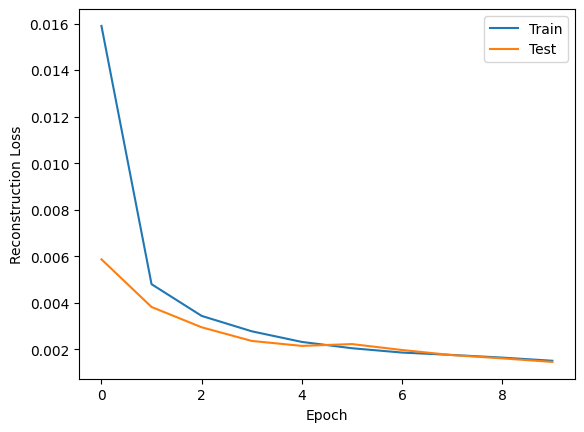

Final Train Loss: 0.0015101586744042316
Final Test Loss: 0.001460267510265112


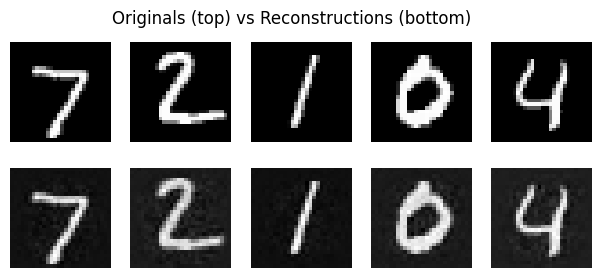

In [ ]:
autoencoder300 = AutoEncoder(in_out_size=784, enc_hidden=1000, dec_hidden=1000, bottleneck_k=300, device=device)
train_losses, test_losses = train_test_autoencoder(autoencoder300, mnist_train_loader, mnist_test_loader, epochs=10, lr=0.001, plot=True, device=device)

print(f'Final Train Loss: {train_losses[-1]}')
print(f'Final Test Loss: {test_losses[-1]}')

visualize_reconstructions(autoencoder300, mnist_test_loader)

Principle Component Analysis (PCA)

90% variance explained by 87 components
95% variance explained by 154 components
99% variance explained by 331 components


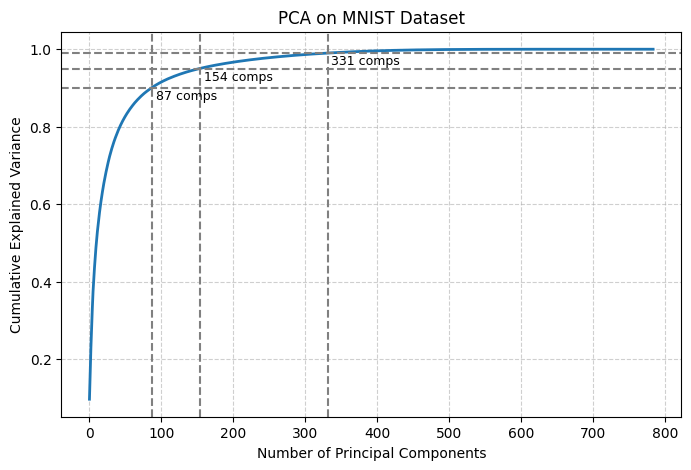

In [ ]:
from sklearn.decomposition import PCA

# Flatten the MNIST dataset for PCA
def get_flattened_mnist(train_loader):
    all_images = []
    for images, _ in train_loader:
        images = images.view(images.size(0), -1)
        all_images.append(images)
    return torch.cat(all_images, dim=0)

# Get training data
mnist_train_data = get_flattened_mnist(mnist_train_loader)
mnist_train_data_np = mnist_train_data.numpy()

# Fit PCA
pca = PCA()
pca.fit(mnist_train_data_np)

# Find cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(cumulative_variance, linewidth=2)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA on MNIST Dataset')
plt.grid(True, linestyle='--', alpha=0.6)

for threshold in [0.9, 0.95, 0.99]:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    plt.axhline(threshold, color='gray', linestyle='--')
    plt.axvline(n_components, color='gray', linestyle='--')
    plt.text(n_components+5, threshold-0.03, f"{n_components} comps", fontsize=9)
    print(f"{threshold*100:.0f}% variance explained by {n_components} components")

plt.show()


Auto-Encoder with dropout

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

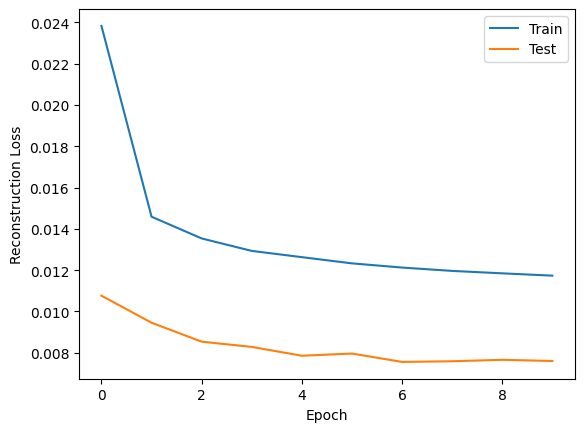

Final Train Loss: 0.011735492657973313
Final Test Loss: 0.007601022568996996


In [ ]:
autoencoder_dropout = AutoEncoder(in_out_size=784, enc_hidden=1000, dec_hidden=1000, bottleneck_k=300, dropout_prob=0.3, device=device)
train_losses, test_losses = train_test_autoencoder(autoencoder_dropout, mnist_train_loader, mnist_test_loader, epochs=10, lr=0.001, plot=True, device=device)

print(f'Final Train Loss: {train_losses[-1]}')
print(f'Final Test Loss: {test_losses[-1]}')

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

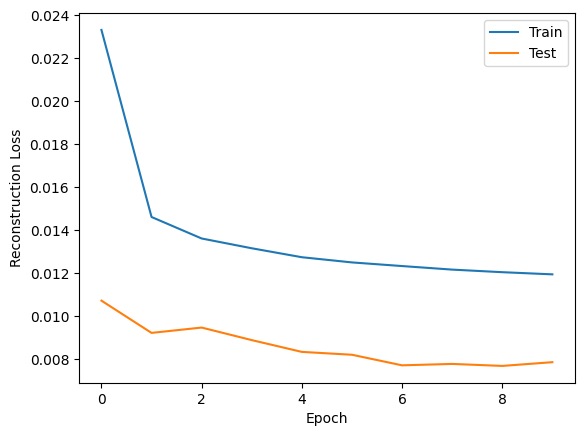

Final Train Loss: 0.011938738380509144
Final Test Loss: 0.00784914386458695


In [ ]:
autoencoder_dropout_large = AutoEncoder(in_out_size=784, enc_hidden=1000, dec_hidden=1000, bottleneck_k=500, dropout_prob=0.3, device=device)
train_losses, test_losses = train_test_autoencoder(autoencoder_dropout_large, mnist_train_loader, mnist_test_loader, epochs=10, lr=0.001, plot=True, device=device)

print(f'Final Train Loss: {train_losses[-1]}')
print(f'Final Test Loss: {test_losses[-1]}')

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

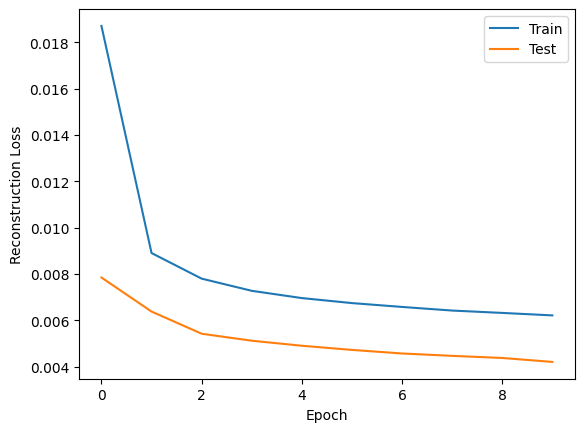

Final Train Loss: 0.0062183073358431555
Final Test Loss: 0.004212044895393774


In [ ]:
autoencoder_dropout = AutoEncoder(in_out_size=784, enc_hidden=1000, dec_hidden=1000, bottleneck_k=300, dropout_prob=0.1, device=device)
train_losses, test_losses = train_test_autoencoder(autoencoder_dropout, mnist_train_loader, mnist_test_loader, epochs=10, lr=0.001, plot=True, device=device)

print(f'Final Train Loss: {train_losses[-1]}')
print(f'Final Test Loss: {test_losses[-1]}')

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

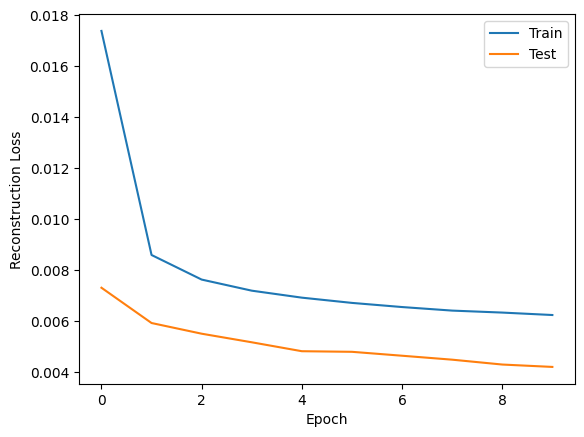

Final Train Loss: 0.006220016956154598
Final Test Loss: 0.004182094073621556


In [ ]:
autoencoder_dropout = AutoEncoder(in_out_size=784, enc_hidden=1000, dec_hidden=1000, bottleneck_k=500, dropout_prob=0.1, device=device)
train_losses, test_losses = train_test_autoencoder(autoencoder_dropout, mnist_train_loader, mnist_test_loader, epochs=10, lr=0.001, plot=True, device=device)

print(f'Final Train Loss: {train_losses[-1]}')
print(f'Final Test Loss: {test_losses[-1]}')

Get trained model of auto encoder to use for next experiments

In [ ]:
autoencoder300 = AutoEncoder(in_out_size=784, enc_hidden=1000, dec_hidden=1000, bottleneck_k=300, device=device)
train_losses, test_losses = train_test_autoencoder(autoencoder300, mnist_train_loader, mnist_test_loader, epochs=10, lr=0.001, plot=False, device=device)

trained_encoder = autoencoder300.encoder

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
class EncoderClassifier(nn.Module):
  def __init__(self, encoder, num_classes=10, device='cpu'):
    super().__init__()
    self.encoder = encoder # using pretrained or random
    self.classifier = nn.Linear(encoder.k, num_classes) # softmax is applied in the loss function

    self.to(device)

  def forward(self, x):
    z = self.encoder(x)
    out = self.classifier(z)
    return out


def train_test_classifier(train_loader, test_loader, pretrained_encoder=None, freeze_encoder=False, epochs=10, lr=0.001, plot=False, device='cpu'):
  # Choose encoder
  if pretrained_encoder is None:
    # Random encoder init
    encoder = Encoder(input_size=784, enc_hidden=1000, bottleneck_k=300, device=device)
  else:
    # Pretrained encoder
    encoder = pretrained_encoder

  # Make classifier
  model = EncoderClassifier(encoder, num_classes=10, device=device)

  # Freeze encoder if needed, setup optimizer accordingly
  if freeze_encoder:
    for param in model.encoder.parameters():
      param.requires_grad = False
    optimizer = optim.Adam(model.classifier.parameters(), lr=lr)
  else:
    optimizer = optim.Adam(model.parameters(), lr=lr)

  # Setup Loss
  loss_fn = nn.CrossEntropyLoss() # to use softmax

  train_losses = []
  test_losses = []

  # Train loop
  for epoch in tqdm(range(epochs)):
    model.train()
    total_train_loss = 0.0

    for batch_idx, (x,y) in enumerate(train_loader):
      x, y = x.to(device), y.to(device)
      x = x.view(x.size(0), -1)

      optimizer.zero_grad()
      outputs = model(x)
      loss = loss_fn(outputs, y)
      loss.backward()
      optimizer.step()

      total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on test data
    model.eval()
    total_test_loss = 0

    with torch.no_grad():
      for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0), -1)

        outputs = model(x)
        loss = loss_fn(outputs, y)
        total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

  if plot:
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Testing Loss')
    plt.show()

  return model, train_losses, test_losses

4 Cases

  0%|          | 0/10 [00:00<?, ?it/s]

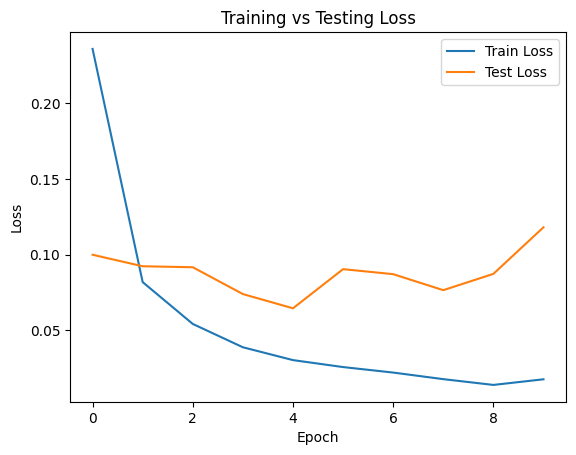

Final Train Loss: 0.017780797808917104
Final Test Loss: 0.1180464920454483


In [ ]:
# 1. Random encoder, train all
classifer1, train_losses1, test_losses1 = train_test_classifier(mnist_train_loader, mnist_test_loader, pretrained_encoder=None, freeze_encoder=False, plot=True)

print(f'Final Train Loss: {train_losses1[-1]}')
print(f'Final Test Loss: {test_losses1[-1]}')

  0%|          | 0/10 [00:00<?, ?it/s]

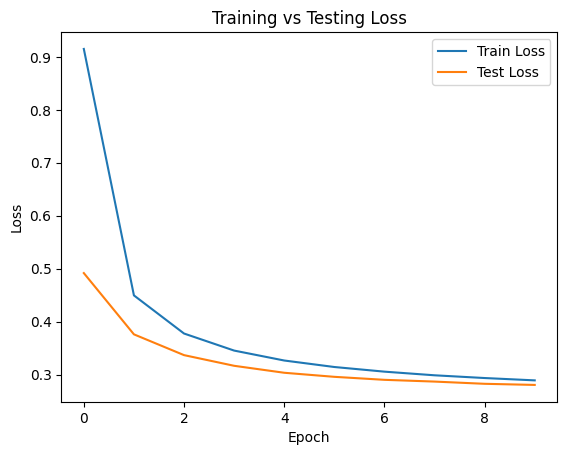

Final Train Loss: 0.2892234117936478
Final Test Loss: 0.280634510377422


In [ ]:
# 2. Pretrained encoder, freeze
classifer2, train_losses2, test_losses2 = train_test_classifier(mnist_train_loader, mnist_test_loader, pretrained_encoder=trained_encoder, freeze_encoder=True, plot=True)

print(f'Final Train Loss: {train_losses2[-1]}')
print(f'Final Test Loss: {test_losses2[-1]}')

  0%|          | 0/10 [00:00<?, ?it/s]

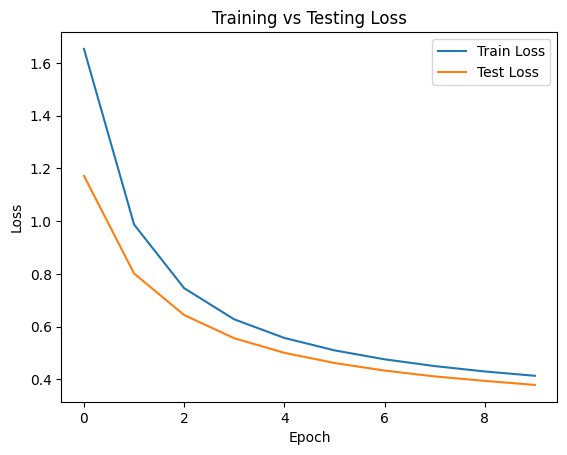

Final Train Loss: 0.4139686146143403
Final Test Loss: 0.3793280191719532


In [ ]:
# 3. Random encoder, freeze
classifer3, train_losses3, test_losses3 = train_test_classifier(mnist_train_loader, mnist_test_loader, pretrained_encoder=None, freeze_encoder=True, plot=True)

print(f'Final Train Loss: {train_losses3[-1]}')
print(f'Final Test Loss: {test_losses3[-1]}')

  0%|          | 0/10 [00:00<?, ?it/s]

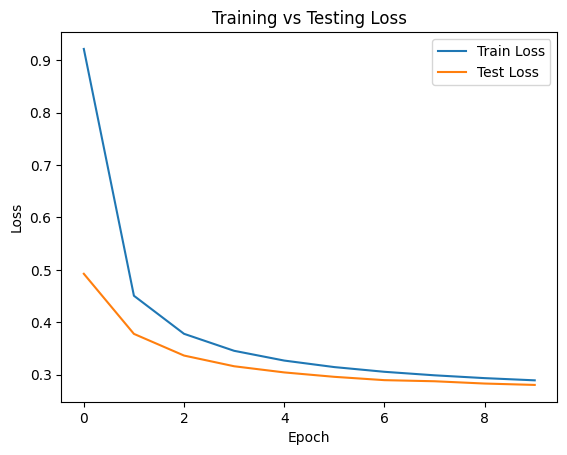

Final Train Loss: 0.28928380979022494
Final Test Loss: 0.28053761934861543


In [ ]:
# 4. Pretrained encoder, train all
classifer4, train_losses4, test_losses4 = train_test_classifier(mnist_train_loader, mnist_test_loader, pretrained_encoder=trained_encoder, freeze_encoder=False, plot=True)

print(f'Final Train Loss: {train_losses4[-1]}')
print(f'Final Test Loss: {test_losses4[-1]}')

# 2. Transfer Learning

Get CIFAR dataset

In [4]:
# CIFAR-10 (32x32 RGB)
cifar_tfm = transforms.Compose([transforms.ToTensor()])
cifar_train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=cifar_tfm)
cifar_test_ds  = datasets.CIFAR10(root="./data", train=False, download=True, transform=cifar_tfm)

cifar_train_loader = DataLoader(cifar_train_ds, batch_size=128, shuffle=True, num_workers=2)
cifar_test_loader  = DataLoader(cifar_test_ds,  batch_size=256, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:01<00:00, 106MB/s]


Simple CNN for CIFAR

In [5]:
class CIFARConvNet(nn.Module):
  def __init__(self, input_size=(3,32,32), conv_channels=[32, 64], hidden_layers=[128], num_classes=10, kernel_size=3, dropout=0.25, device='cpu'):
    super().__init__()

    in_channels = input_size[0]

    # Convolutional blocks
    conv_layers = []
    for out_channels in conv_channels:
      conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1))
      conv_layers.append(nn.ReLU())
      conv_layers.append(nn.MaxPool2d(2))

      if dropout > 0:
        conv_layers.append(nn.Dropout2d(dropout))

      in_channels = out_channels

    self.conv_layers = nn.Sequential(*conv_layers)

    # Get flattened size with dummy tensor
    with torch.no_grad():
      dummy = torch.zeros(1, *input_size)
      dummy_out = self.conv_layers(dummy)
      flattened_dim = dummy_out.view(1, -1).size(1)

    # Fully connected layers
    fc_layers = []
    input_dim = flattened_dim
    for hidden_dim in hidden_layers:
      fc_layers.append(nn.Linear(input_dim, hidden_dim))
      fc_layers.append(nn.ReLU())

      if dropout > 0:
        fc_layers.append(nn.Dropout(dropout))

      input_dim = hidden_dim

    # Output classifier layer
    fc_layers.append(nn.Linear(input_dim, num_classes))
    self.fc_layers = nn.Sequential(*fc_layers)

    self.to(device)

  def forward(self, x):
    x = self.conv_layers(x)
    x = torch.flatten(x, 1)
    x = self.fc_layers(x)
    return x

def train_test_cnn(model, train_loader, test_loader, epochs=10, lr=0.001, plot=False, device='cpu'):
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  loss_fn = nn.CrossEntropyLoss()

  train_losses = []
  test_losses = []

  for epoch in tqdm(range(epochs)):
    # Train loop
    model.train()
    total_train_loss = 0.0
    for x, y in train_loader:
      x, y = x.to(device), y.to(device)
      optimizer.zero_grad()
      preds = model(x)
      loss = loss_fn(preds, y)
      loss.backward()
      optimizer.step()
      total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Test loop
    model.eval()
    total_test_loss = 0.0
    with torch.no_grad():
      for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x)
        loss = loss_fn(preds, y)
        total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

  if plot:
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

  return model, train_losses, test_losses

  0%|          | 0/10 [00:00<?, ?it/s]

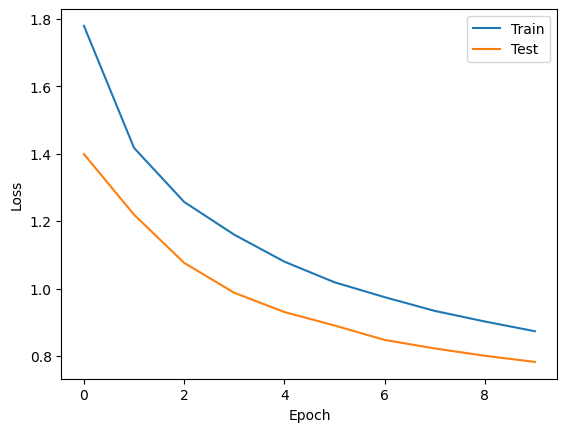

Final Train Loss: 0.8732220868930183
Final Test Loss: 0.7821422562003135


In [8]:
cnn = CIFARConvNet(input_size=(3,32,32), conv_channels=[32, 64, 128], hidden_layers=[256], num_classes=10, kernel_size=3, dropout=0.25, device=device)
cnn, train_losses_cnn, test_losses_cnn = train_test_cnn(cnn, cifar_train_loader, cifar_test_loader, epochs=10, lr=0.001, plot=True, device=device)

print(f'Final Train Loss: {train_losses_cnn[-1]}')
print(f'Final Test Loss: {test_losses_cnn[-1]}')

In [14]:
torch.save(
    cnn.state_dict(),
    '/content/drive/MyDrive/CS462_HW2_Models/cifar_baseline_cnn.pth'
)
print("Saved cifar_baseline_cnn.pth to Google Drive.")

Saved cifar_baseline_cnn.pth to Google Drive.


In [ ]:
# Load saved network (after initializing architecture)
cnn.load_state_dict(torch.load('/content/drive/MyDrive/CS462_HW2_Models/cifar_baseline_cnn.pth'))
cnn.to(device)